<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

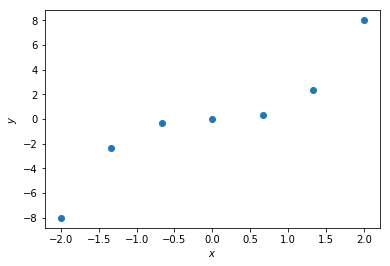

In [247]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

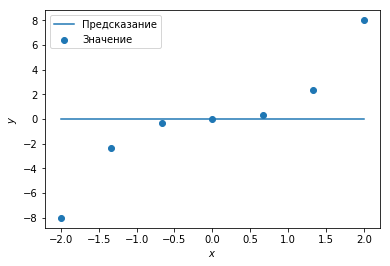

In [248]:
tree0 = np.full(X.shape[0], np.mean(X))

plt.scatter(X, y, label = 'Значение')
plt.plot(X, tree0, label = 'Предсказание')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

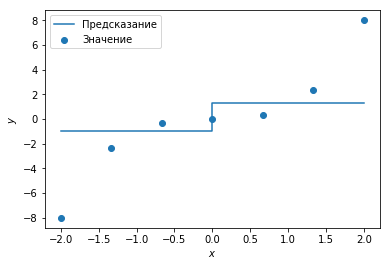

In [249]:
t = 0
x_for_node = np.array([-2, t, t, 2])
node1 = np.full(2, np.mean(X[X<=t]))
node1 =  np.hstack((node1, np.full(2, np.mean(X[X>t]))))

plt.scatter(X, y, label = 'Значение')
plt.plot(x_for_node, node1, label = 'Предсказание')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [250]:
def regression_var_criterion(X, y, t):
    return np.var(y) - X[X<=t].shape[0]/X.shape[0]*np.var(y[0:X[X<=t].shape[0]]) -\
        X[X>t].shape[0]/X.shape[0]*np.var(y[X[X<=t].shape[0] - 1:y.shape[0] - 1])
    #pass 

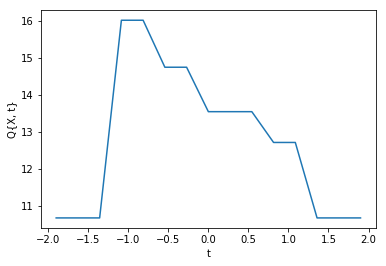

In [252]:
t = np.linspace(-1.9, 1.9,15)
print_Q = np.array([])
for i in t:
    print_Q = np.hstack((print_Q, regression_var_criterion(X, y, i)))
plt.plot(t, print_Q)
plt.xlabel('t')
plt.ylabel('Q{X, t}');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- <font color='red'>Нет</font>

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

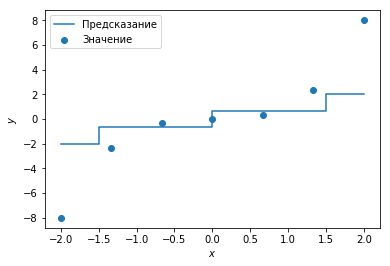

In [81]:
t1 = -1.5
t2 = 1.5
x_for_node = np.hstack((x_for_node, np.array([t1, t1, t2, t2])))
x_for_node = np.sort(x_for_node)
node2 = np.array([])
for i in range(0, x_for_node.shape[0] - 1, 2):
    node2 =  np.hstack((node2, np.full(2, np.mean(X[(X >= x_for_node[i]) & (X <= x_for_node[i+1])]))))

plt.scatter(X, y, label = 'Значение')
plt.plot(x_for_node, node2, label = 'Предсказание')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');


**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- <font color='red'>7</font>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [232]:
df = pd.read_csv('.../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [233]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [234]:
df['age_years'] = (df.age/365.25).round().astype('int')

In [235]:
df = df.join(pd.DataFrame(pd.get_dummies(df['cholesterol'], prefix = 'cholesterol_bin')).astype('int'))
df = df.join(pd.DataFrame(pd.DataFrame(pd.get_dummies(df['gluc'], prefix = 'gluc_bin')).astype('int')))
df.drop(['gluc', 'cholesterol', 'age'], axis = 1, inplace = True)


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [236]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['cardio'], axis = 1),
                                                      df.cardio, test_size=0.3,random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [237]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/release/bin/'

In [238]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file='.../../img/tree.dot')

In [239]:
import pydot

(graph,) = pydot.graph_from_dot_file('.../../img/tree.dot')
graph.write_png('.../../img/tree.png')

In [240]:
from PIL import Image

img = Image.open(open('.../../img/tree.png', 'rb'))
img.show()

In [241]:
print(X_train.columns[3], '', X_train.columns[8],'', X_train.columns[11])

ap_hi  age_years  cholesterol_bin_3


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- <font color='red'>age, ap_hi, chol=3</font>

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [242]:
acc1 = tree.score(X_valid, y_valid)

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [244]:
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid=tree_params, cv=5)
tree_grid.fit(X_train, y_train)
results=tree_grid.cv_results_

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

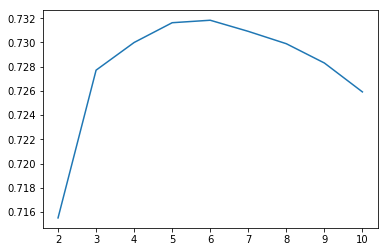

In [245]:
plt.plot(range(2, 11), results['mean_test_score']);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [230]:
results['mean_test_score'].max()
acc2 = tree_grid.score(X_valid, y_valid)
print((acc2 - acc1)/acc1*100)

0.013203934772554172


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- <font color='red'>нет, нет</font>

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- <font color='red'>Верхнее артериальное давление от 140 до 160 (мм рт.ст.)</font>
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [195]:
df.gender = df.gender.replace({1: 0, 2: 1})

In [196]:
df = df.join(pd.DataFrame(pd.get_dummies(pd.cut(df['age_years'], bins=[45, 50, 55, 60, 65], labels=False),
                                         prefix = 'age')).astype('int'))
df = df.join(pd.DataFrame(pd.get_dummies(pd.cut(df['ap_hi'], bins=[120, 140, 160, 180], labels=False),
                                         prefix = 'ap_hi')).astype('int'))

In [197]:
df.drop(['age_years', 'ap_hi'], axis = 1, inplace = True)

In [211]:
df_tree = df.drop(['gluc_bin_1','gluc_bin_2','gluc_bin_3', 'cardio','alco','active', 'ap_lo', 'height',
                    'weight'], 
                   axis = 1) 

In [212]:
X_train, X_valid, y_train, y_valid = train_test_split(df_tree, df.cardio, test_size=0.3,random_state=17)

In [213]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file='.../../img/tree_ssz.dot')

In [215]:
(graph,) = pydot.graph_from_dot_file('.../../img/tree_ssz.dot')
graph.write_png('.../../img/tree_ssz.png')
img = Image.open(open('.../../img/tree_ssz.png', 'rb'))
img.show()

In [216]:
print(X_train.columns[10])

ap_hi_1.0
